In [1]:
import numpy as np
from karabo.imaging.imager_oskar import OskarDirtyImager
from karabo.imaging import imager_wsclean
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.visibility import Visibility
from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.simulator_backend import SimulatorBackend
from karabo_simutils import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from matplotlib.colors import PowerNorm
from scipy.signal import convolve2d
import glob
import matplotlib.patches as patches
#mpl.use('Tkagg')
%matplotlib inline
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

## Simulation of Surajit's Model ##

1.20000004768404
43.014027 (2048, 2048) SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BTYPE   = 'Intensity'                                                           OBJECT  = '        '                                                            

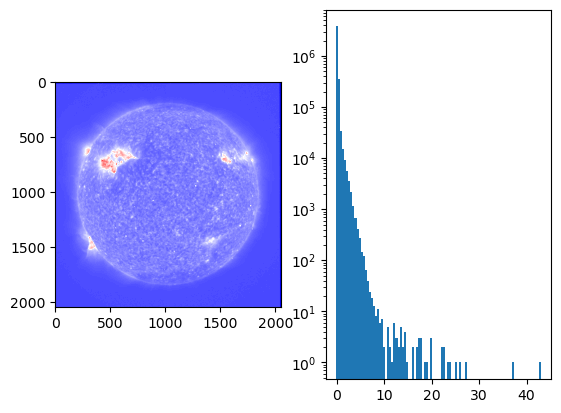

In [2]:
# sc1: Surajit Model 

#telescope_path = '/media/rohit/sdata/ska-solar-files/meerkat.tm'
#telescope_path = '/data/rohit/skao_repo/ska1mid.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AAstar.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA2.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA1.tm'
#telescope_path = '/media/rohit/sdata/ska-solar-files/mwa.phase1.tm'
telescope_path = '/data/rohit/skao_repo/ska1low.tm'
telescope_name= 'ska-low'
hour_=0
minutes_=1
noise_enable_ = False
enable_array_beam=False
skao_repo_tel_path = '/data/rohit/skao_repo/'
tel_all = get_telescope(skao_repo_tel_path) # 0 is SKA, and 1 is SKA-precursor
telescope_list = ['skalow','skamid','mwa','meerkat']
ska_aa_list = ['AA0.5','AA1','AA2','AAs','Full']
mid_bands=['1','3']
nt=1; tel = telescope_list[nt] # Put in your telescope in `tel`

#---------
skymodel_path='/data/rohit/solar-sky-models/solar_image_model.fits'
#skymodel_path='/data/rohit/solar-sky-models/mark_skymodels/muram_560000_los0_grff.ncdf'
path = '/data/rohit/ska-solar-sim-repo-paper/sc1/run3/'

ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
skymodel_cellsize=22.5 # in arcsec

smdata1, smhead1 = fits.getdata(skymodel_path,header=True)
smdata1 = smdata1[0][0]
#smdata1[smdata1<0.1] = 0
#smdata1[smdata1>10] = 0
print(smhead1['CDELT2']*3600)
print(smdata1.max(),smdata1.shape,smhead1 )
f,(ax0,ax1) = plt.subplots(1,2)
ax0.imshow(smdata1,cmap='seismic',norm=PowerNorm(0.2))
ax1.hist(smdata1.flatten(),bins=100)
ax1.set_yscale('log')
plt.savefig(skymodel_path+'.png')


Number of Baselines: 130816
Maximum Baseline 65412.89611017922
[18.91964599 17.83852336 16.87427885 16.00893122 15.22800775 14.51972832
 13.87440706 13.28400676 12.7418024  12.24212387 11.78015694 11.35178759
 10.95347926 10.58217487 10.23521832  9.91029076  9.60535873  9.31863161
  9.04852634  8.79363828  8.55271668  8.32464423  8.10841971  7.90314326
  7.70800392  7.52226889  7.34527432  7.17641744  7.01514964  6.86097052
  6.71342277  6.57208755  6.43658059  6.30654866  6.18166651  6.06163415
  5.94617445  5.83503101  5.72796622  5.62475962  5.52520635  5.42911581
  5.33631041  5.24662452  5.15990345  5.07600258  4.99478654  4.91612849
  4.83990944  4.76601769  4.69434825  4.62480235  4.55728699  4.49171452
  4.42800225  4.36607215  4.30585047  4.24726747  4.19025717  4.13475707
  4.08070796  4.02805366  3.97674088  3.92671898  3.87793986  3.83035778
  3.7839292   3.73861268  3.69436874  3.65115975  3.60894981  3.56770467
  3.52739162  3.48797943  3.44943822  3.41173944  3.37485577 

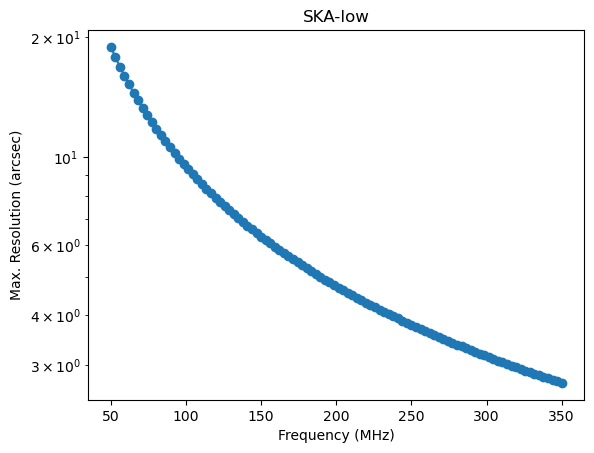

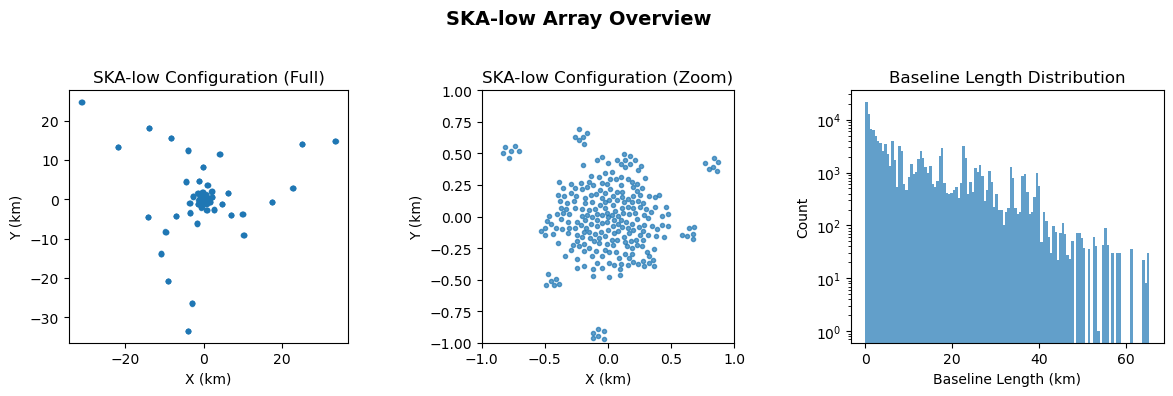

In [3]:
# Step-2 Analyse Telescope Model 
layout=np.loadtxt(telescope_path+'/layout.txt')
nant=len(layout)
nb=int(nant*(nant-1)*0.5)
print('Number of Baselines:',nb)
base_length=[0]*nb
k=0
for i in range(nant):
    for j in range(i,nant):
        if(i!=j):
            base_length[k] = np.sqrt((layout[i][0]-layout[j][0])**2 + (layout[i][1]-layout[j][1])**2)
            k=k+1
base_length=np.array(base_length)
print('Maximum Baseline',base_length.max())
#----------------------------
freq_list0 = np.linspace(0.5,3.5,100)*100 # in MHz
beamsize_arr = 3.e8/base_length.max()/(freq_list0*1.e6)
beamsize_arr_arcsec = beamsize_arr*180/np.pi*3600
print(beamsize_arr_arcsec)
f,ax=plt.subplots(1,1)
ax.plot(freq_list0,beamsize_arr_arcsec,'o-')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Max. Resolution (arcsec)')
ax.set_title('SKA-low')
ax.set_yscale('log')
plt.show()


#-----------------------------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
# --- Panel 1: Full SKA-mid layout ---
for ax in [ax0, ax1]:
    ax.plot(layout[:, 0] / 1e3, layout[:, 1] / 1e3, 'o', ms=3, alpha=0.7)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_aspect('equal')
ax0.set_title('SKA-low Configuration (Full)')
ax1.set_title('SKA-low Configuration (Zoom)')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
# --- Panel 3: Baseline length distribution ---
ax2.hist(base_length / 1e3, bins=120, color='tab:blue', alpha=0.7)
ax2.set_xlabel('Baseline Length (km)')
ax2.set_ylabel('Count')
ax2.set_yscale('log')
ax2.set_title('Baseline Length Distribution')
# Improve layout and appearance
fig.suptitle('SKA-low Array Overview', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])


In [4]:

i=0
freq_list = [100,500,1500,3000]
start_frequency_hz_ = freq_list[i]*1.e6
beam_size_arcsec = 10
flux_cutoff = 0 # high freq cut-off

print('Beam (arcsec)',beam_size_arcsec)
print("Frequency (MHz): ",start_frequency_hz_)
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"
solar_map=smdata1
solar_map_jy=solar_map/np.nanmax(solar_map)#*20*1.e4*(start_frequency_hz_/2.4e8)**1
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
ra_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
dec_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
print('Resolution: ',smhead1['CDELT1']*3600,' arcsec')
ra_grid,dec_grid=np.meshgrid(ra_arr*smhead1['CDELT1'],dec_arr*smhead1['CDELT2'])
ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
#solar_map_jy[solar_map_jy > flux_cutoff] = 0 # only 2-D
solar_map_jy = solar_map_jy/np.nanmax(solar_map_jy)
flux=solar_map_jy.flatten()
#flux = [x for x in flux if x != 0]
#flux = flux0[flux0 > flux_cutoff]
sky_model_ra = ra_grid[solar_map_jy > flux_cutoff] # 1-D array
sky_model_dec = dec_grid[solar_map_jy > flux_cutoff]
sky_model_ra=ra_grid.flatten();sky_model_dec=dec_grid.flatten()
print('Shape: ',smhead1['CDELT1'],smhead1['CUNIT1'],sky_model_ra)
print(ra_grid.shape,len(flux),sky_model_ra[np.where(flux>0)].shape)



Beam (arcsec) 10
Frequency (MHz):  100000000.0
Resolution:  -1.20000004768404  arcsec
Shape:  -0.0003333333465789 deg [249.48300001 249.48266668 249.48233335 ... 248.80133332 248.80099999
 248.80066665]
(2048, 2048) 4194304 (3595425,)


In [5]:
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"# Simulation starts 
sky = SkyModel()
sky_data = np.array([sky_model_ra, sky_model_dec, flux,np.zeros(len(flux)), \
                    np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),\
                    np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux))]).T
#sky_data=sky_data[0:16000,:]
ntchan = 1
nchan = 1
sky.add_point_sources(sky_data)
noise_enable_ = False
enable_array_beam = False

#telescope_name="SKA1MID"
#telescope=Telescope.get_SKA1_LOW_Telescope()
#dtime=datetime(2000, 1, 1, 10, 0, 00, 0) # MeerKAT/ SKA-mid
dtime=datetime(2000, 1, 1, 4, 0, 00, 0) # MWA / SKA-low
backend=SimulatorBackend.OSKAR
#telescope = Telescope.constructor(telescope_name, backend=backend)
telescope=Telescope.read_OSKAR_tm_file(telescope_path)
telescope.read_OSKAR_tm_file(telescope_path)
print('Simulating Now..')
simulation = InterferometerSimulation(vis_path=vis_filename, ms_file_path=ms_filename,
    channel_bandwidth_hz=40.e3, time_average_sec=1, noise_enable=noise_enable_, use_gpus=False,
    noise_seed="time", noise_freq="Range", noise_rms="Range", 
    noise_start_freq=1.e9, noise_inc_freq=1.e8, noise_number_freq=24, 
    noise_rms_start=0, noise_rms_end=0, enable_numerical_beam=enable_array_beam,
    enable_array_beam=enable_array_beam) 
observation = Observation(mode='Tracking',phase_centre_ra_deg=ra_sun_center, start_date_and_time=dtime, 
    length=timedelta(hours=hour_, minutes=minutes_, seconds=0, milliseconds=0), 
    phase_centre_dec_deg=dec_sun_center, number_of_time_steps=ntchan, 
    start_frequency_hz=start_frequency_hz_, frequency_increment_hz=1, 
    number_of_channels=nchan,) 
visibility = simulation.run_simulation(telescope, sky, observation, backend=backend)


Simulating Now..
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc1/run3/solar_freq_100_ska-low.vis


In [18]:

imgsize=4096
cellsize_arcsec=1.2 #beam_size_arcsec/npix_per_beam
cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
print('Cellsize:',cellsize_arcsec,'Beam (arcsec):',beam_size_arcsec,'Max length:')
print('Field of View (deg):',imgsize*cellsize_arcsec/3600.)
dirty_imager = OskarDirtyImager(
    OskarDirtyImagerConfig(
        imaging_npixel=imgsize,
        imaging_cellsize=cellsize_rad,
    ))
dirty_oskar_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+"_oskar.fits"
dirty_image = dirty_imager.create_dirty_image(visibility,output_fits_path=dirty_oskar_img)
dirty_wsclean_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+"_wsclean.fits"
img_cmd = 'wsclean \
        -size '+str(imgsize)+' '+str(imgsize)+' \
        -name '+dirty_wsclean_img+' \
        -scale '+str(cellsize_rad)+'rad \
        -super-weight 12\
        -maxuv-l 600000 -minuv-l 1500\
        -mgain 0.8 -niter 1000 -auto-threshold 3 \
        -channels-out '+str(nchan)+' '+ms_filename
print(img_cmd)
#-multiscale -scale 32amin
try:
    restored = imager_wsclean.create_image_custom_command(command=img_cmd)
except:
    pass # doing nothing on exception    

Cellsize: 1.2 Beam (arcsec): 10 Max length:
Field of View (deg): 1.3653333333333333


/home/rohit/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/imaging/image.py:119: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


wsclean         -size 4096 4096         -name /data/rohit/ska-solar-sim-repo-paper/sc1/run3/solar_freq_100_ska-low_wsclean.fits         -scale 5.817764173314431e-06rad         -super-weight 12        -maxuv-l 600000 -minuv-l 1500        -mgain 0.8 -niter 1000 -auto-threshold 3         -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/sc1/run3/solar_freq_100_ska-low.ms
Creating /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-EyCcrJuLUG for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-EyCcrJuLUG && OPENBLAS_NUM_THREADS=1 wsclean         -size 4096 4096         -name /data/rohit/ska-solar-sim-repo-paper/sc1/run3/solar_freq_100_ska-low_wsclean.fits         -scale 5.817764173314431e-06rad         -super-weight 12        -maxuv-l 600000 -minuv-l 1500        -mgain 0.8 -niter 1000 -auto-threshold 3         -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/sc1/run3/solar_freq_100_ska-low.ms]
WSClean output:
[
WSClean ve

In [ ]:
kernel = np.ones((20, 20))
solar_map_conv = convolve2d(solar_map, kernel, mode='same', boundary='fill', fillvalue=0)
solar_map_conv = solar_map_conv / np.max(solar_map_conv)

dirty_wsclean_img = '/data/rohit/ska-solar-sim-repo-paper/sc1/run3/solar_freq_100_ska-low_wsclean.fits-image.fits'
mapsun, head = fits.getdata(dirty_wsclean_img,header=True)
#print(smdata1.max(),mapsun.max())
mapsun =  mapsun[0][0]/np.max(mapsun) * np.nanmax(solar_map)
print(solar_map_jy.max(),mapsun.max(),smhead1['CDELT1']*3600)
print(head['CDELT1']*3600,head['CRVAL1'],head['CRVAL2'],smhead1['CRVAL1'],smhead1['CRVAL2'])
print(head['CRPIX1'],head['CRPIX2'],smhead1['CRPIX1'],smhead1['CRPIX2'])

img_ra =  (np.arange(smdata1.shape[0]) - smhead1['CRPIX1'])*smhead1['CDELT1']*3600
img_dec =  (np.arange(smdata1.shape[1]) - smhead1['CRPIX2'])*smhead1['CDELT2']*3600
ra_arr =  (np.arange(mapsun.shape[0]) - head['CRPIX1'])*head['CDELT1']*3600
dec_arr =  (np.arange(mapsun.shape[1]) - head['CRPIX2'])*head['CDELT2']*3600

#img_x_pix, img_y_pix = w.world_to_pixel_values(img_ra, img_dec);img_x_pix = int(round(img_x_pix));img_y_pix = int(round(img_y_pix))


# ----------------------------------------------------------
# Helper: Set ticks and labels
# ----------------------------------------------------------
def set_ticks_labels(ax, xarr, yarr, xstep, ystep,
                    xscale=1.0, yscale=1.0,
                    xlabel='X (arcsec)', ylabel='Y (arcsec)',
                    tick_fs=9, label_fs=10):
    ax.set_xticks(np.arange(len(xarr))[::xstep])
    ax.set_yticks(np.arange(len(yarr))[::ystep])
    ax.set_xticklabels(np.round(xarr[::xstep] * xscale, 1), fontsize=tick_fs)
    ax.set_yticklabels(np.round(yarr[::ystep] * yscale, 1), fontsize=tick_fs)
    ax.set_xlabel(xlabel, fontsize=label_fs)
    ax.set_ylabel(ylabel, fontsize=label_fs)

# ----------------------------------------------------------
# Helper: One panel plotter to avoid repetition
# ----------------------------------------------------------
def plot_panel(ax, data, title, cmap='seismic',
            power=0.3, vmin=None, vmax=None,
            xlabel='X Pixels', ylabel='Y Pixels',
            title_fs=9):   # reduced font size
    
    im = ax.imshow(
        data, origin='lower', aspect='equal', cmap=cmap,
        norm=PowerNorm(power, vmin=vmin, vmax=vmax)
    )
    ax.set_title(title, fontsize=title_fs, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Flux density (SFU)', fontsize=10)
    return ax

def zoom_center(ax, data, frac=0.5):
    """Zoom into the central region of the image using x/y limits."""
    ny, nx = data.shape
    half = (1 - frac) / 2      # for frac=0.5 → half=0.25
    ax.set_xlim(nx*half, nx*(1-half))
    ax.set_ylim(ny*half, ny*(1-half))

ny, nx = solar_map_jy.shape  # image dimensions
xmin, xmax = nx*0.25, nx*0.75
ymin, ymax = ny*0.25, ny*0.75


# ----------------------------------------------------------
# Create figure
# ----------------------------------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,8), constrained_layout=True)

# --- Panel 1: Simulated Model ---
plot_panel(
    ax0,
    solar_map_jy * np.nanmax(solar_map),
    title='Simulated Sky Model',
    title_fs=9,
    vmin=-1,
    vmax=np.nanmax(solar_map),
)
set_ticks_labels(ax0, img_ra, img_dec, 128, 128)
ax0.set_xlim(1024-512, 1024+512)
ax0.set_ylim(1024-512, 1024+512)
circle = patches.Circle( (1024-160, 1024-160),        # center in pixel coordinates
    radius=80,        # radius in pixels
    edgecolor='yellow',
    facecolor='none',
    linewidth=2
)
ax0.add_patch(circle)
ax0.grid()

# --- Panel 2: Reconstruction (cropped) ---
plot_panel(
    ax1,
    mapsun,
    title='Reconstructed Solar Map',
    vmin=2,
    vmax=np.nanmax(mapsun)*0.5,
    title_fs=9
)
set_ticks_labels(ax1,ra_arr,dec_arr,128, 128)
ax1.set_xlim(2048-512, 2048+512)
ax1.set_ylim(2048-512, 2048+512)
circle = patches.Circle( (2048-160, 2048-160),        # center in pixel coordinates
    radius=80,        # radius in pixels
    edgecolor='yellow',
    facecolor='none',
    linewidth=2
)
ax1.add_patch(circle)
ax1.grid()

# --- Panel 3: Convolved Model ---
plot_panel(
    ax2,
    solar_map_conv * np.nanmax(solar_map),
    title='Beam Convolved \n Simulated Sky Model',
    title_fs=9,
    vmin=1,
    vmax=np.nanmax(solar_map),
)
set_ticks_labels(ax2, img_ra, img_dec, 128, 128)
ax2.set_xlim(1024-512, 1024+512)
ax2.set_ylim(1024-512, 1024+512)
# --- Figure Title ---
fig.suptitle('Comparison of Model and Solar Map (UVlim> 4k$\\lambda$) | superuniform 8 ',
            fontsize=14, fontweight='bold', y=1.02)
circle = patches.Circle( (1024-160, 1024-160),        # center in pixel coordinates
    radius=80,        # radius in pixels
    edgecolor='yellow',
    facecolor='none',
    linewidth=2
)
ax2.add_patch(circle)
ax2.grid()
plt.show()

(2048, 2048) (2048, 2048) (8192, 8192)


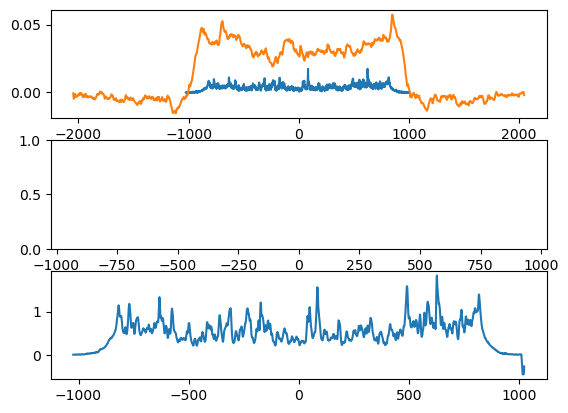

In [ ]:
print(solar_map_jy.shape, solar_map_conv.shape, mapsun.shape)
img_ra_arr = (np.arange(mapsun.shape[0])-int(mapsun.shape[0]/2))*head['CDELT1']*3600
f,(ax0,ax1,ax2) = plt.subplots(3,1)
ax0.plot(ra_arr,solar_map_jy[1024])
ax0.plot(img_ra_arr,mapsun[4096]/100)
ax2.plot(ra_arr,solar_map_conv[1024]*np.nanmax(solar_map))
ax1.set_xlim(ra_arr[0],ra_arr[-1])
plt.show()


## Simulation of Mark's Model ##

0.004209261352323213
0.26482758620689656 (200, 200) (200, 200)


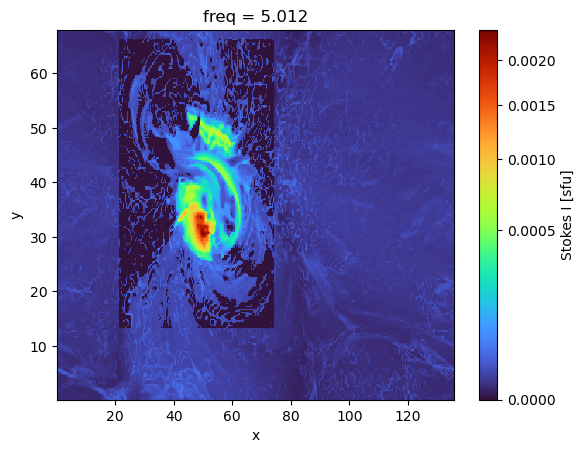

In [12]:
# Step-1 Analyse initial Skymodel

#sc2: Mark's Model 
#telescope_path = '/media/rohit/sdata/ska-solar-files/meerkat.tm'
telescope_path = '/data/rohit/skao_repo/ska1mid.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AAstar.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA2.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA1.tm'
#telescope_path = '/media/rohit/sdata/ska-solar-files/mwa.phase1.tm'
#telescope_path = '/data/rohit/skao_repo/ska1low.tm'
telescope_name= 'ska1mid'
hour_=0
minutes_=1
noise_enable_ = False
enable_array_beam=False
skao_repo_tel_path = '/data/rohit/skao_repo/'
#tel_all = get_telescope(skao_repo_tel_path) # 0 is SKA, and 1 is SKA-precursor
telescope_list = ['skalow','skamid','mwa','meerkat']
ska_aa_list = ['AA0.5','AA1','AA2','AAs','Full']
mid_bands=['1','3']
nt=1; tel = telescope_list[nt] # Put in your telescope in `tel`
ds = xr.load_dataset('/data/rohit/solar-sky-models/mark_skymodels/muram_530000_los0_grff.ncdf')
smdata10 = ds['Stokes I'].sel(freq=10, method='nearest').T.data[50:250,80:280]
smdata5 = ds['Stokes I'].sel(freq=5, method='nearest').T.data[50:250,80:280]
print(smdata10.max())
smdata10[smdata10<2.e-5] = 0
smdata5[smdata5<1.e-5] = 0


ds['Stokes I'].sel(freq=5, method='nearest').T.plot(norm=PowerNorm(0.5), cmap='turbo')
dsx=ds['x']
res_sm2=dsx.data[1]-dsx.data[0] # in arcsec
print(res_sm2,smdata5.shape,smdata10.shape)

Number of Baselines: 19306
Maximum Baseline 157396.94486666212
[3.93142586 1.96571293 1.31047529 0.98285646 0.78628517 0.65523764
 0.56163227 0.49142823 0.4368251  0.39314259 0.35740235 0.32761882
 0.30241737 0.28081613 0.26209506 0.24571412 0.23126034 0.21841255
 0.20691715]


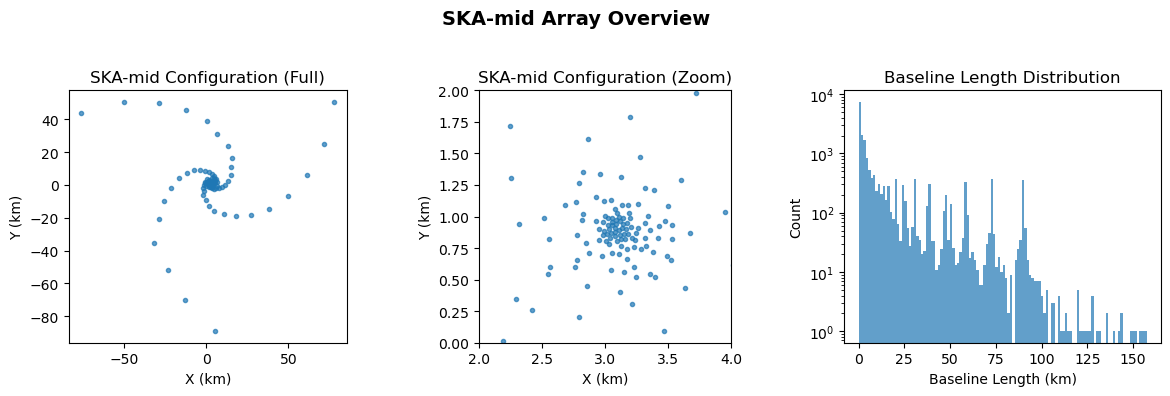

In [ ]:
# Step-2 Analyse Telescope Model 
layout=np.loadtxt(telescope_path+'/layout.txt')
nant=len(layout)
nb=int(nant*(nant-1)*0.5)
print('Number of Baselines:',nb)
base_length=[0]*nb
k=0
for i in range(nant):
    for j in range(i,nant):
        if(i!=j):
            base_length[k] = np.sqrt((layout[i][0]-layout[j][0])**2 + (layout[i][1]-layout[j][1])**2)
            k=k+1
base_length=np.array(base_length)
print('Maximum Baseline',base_length.max())
#----------------------------
freq_list = np.arange(1,20)*100 # in MHz
beamsize_arr = 3.e8/base_length.max()/(freq_list*1.e6)
beamsize_arr_arcsec = beamsize_arr*180/np.pi*3600
print(beamsize_arr_arcsec)
f,ax=plt.subplots(1,1)
ax.plot(freq_list,beamsize_arr_arcsec,'o-')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Max. Resolution (arcsec)')
ax.set_title('SKA-mid')
#ax.set_yscale('log')
plt.close()


#-----------------------------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
# --- Panel 1: Full SKA-mid layout ---
for ax in [ax0, ax1]:
    ax.plot(layout[:, 0] / 1e3, layout[:, 1] / 1e3, 'o', ms=3, alpha=0.7)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_aspect('equal')
ax0.set_title('SKA-mid Configuration (Full)')
ax1.set_title('SKA-mid Configuration (Zoom)')
ax1.set_xlim(2, 4)
ax1.set_ylim(0, 2)
# --- Panel 3: Baseline length distribution ---
ax2.hist(base_length / 1e3, bins=120, color='tab:blue', alpha=0.7)
ax2.set_xlabel('Baseline Length (km)')
ax2.set_ylabel('Count')
ax2.set_yscale('log')
ax2.set_title('Baseline Length Distribution')
# Improve layout and appearance
fig.suptitle('SKA-mid Array Overview', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])


In [ ]:
# Step-3 Generate Karabo Skymodel

path = '/data/rohit/ska-solar-sim-repo-paper/sc2/'

ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
#skymodel_cellsize=22.5 # in arcsec
#-------- Define Image Parameters
#npix_per_beam = 3


i=1
smdata=[smdata5,smdata10]
solar_map=smdata[i]
freq_list = [5,10]
start_frequency_hz_ = freq_list[i]*1.e9
print("Frequency (GHz): ",start_frequency_hz_)
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"
solar_map_jy=solar_map*1.e4#/np.nanmax(solar_map)*20*1.e4*(start_frequency_hz_/2.4e8)**1
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
ra_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
dec_arr=(np.arange(solar_map_jy.shape[1])-int(solar_map_jy.shape[1]/2))
ra_grid,dec_grid=np.meshgrid(ra_arr*res_sm2/3600.,dec_arr*res_sm2/3600.)
ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
sky_model_ra=ra_grid.flatten();sky_model_dec=dec_grid.flatten();flux=solar_map_jy.flatten()
print(sky_model_dec.shape,flux.shape,sky_model_ra,solar_map_jy.max())

Frequency (GHz):  10000000000.0
(40000,) (40000,) [249.13431035 249.13438391 249.13445747 ... 249.1488023  249.14887586
 249.14894943] 42.09261352323213


In [ ]:
# Step-4 Do Observation
#-----------
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+".vis"# Simulation starts 
sky = SkyModel()
sky_data = np.array([sky_model_ra, sky_model_dec, flux,np.zeros(len(flux)), \
                    np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),\
                    np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux))]).T
#sky_data=sky_data[0:16000,:]
sky.add_point_sources(sky_data)
dtime=datetime(2000, 1, 1, 10, 0, 00, 0) # MeerKAT/ SKA-mid
backend=SimulatorBackend.OSKAR
telescope=Telescope.read_OSKAR_tm_file(telescope_path)
telescope.read_OSKAR_tm_file(telescope_path)
noise_enable_ = False
channel_bandwidth_hz_ = 10.e3
time_average_sec_ = 8
hour_ =0;minutes_=0;seconds_=8
nchan = 100
ntchan = 1
simulation = InterferometerSimulation(vis_path=vis_filename, ms_file_path=ms_filename,
    channel_bandwidth_hz=channel_bandwidth_hz_, time_average_sec=time_average_sec_, noise_enable=noise_enable_, use_gpus=True,
    noise_seed="time", noise_freq="Range", noise_rms="Range", 
    noise_start_freq=1.e9, noise_inc_freq=1.e8, noise_number_freq=24, 
    noise_rms_start=0, noise_rms_end=0, enable_numerical_beam=enable_array_beam,
    enable_array_beam=enable_array_beam) 
observation = Observation(mode='Tracking',phase_centre_ra_deg=ra_sun_center, start_date_and_time=dtime, 
    length=timedelta(hours=hour_, minutes=minutes_, seconds=seconds_, milliseconds=0), 
    phase_centre_dec_deg=dec_sun_center, number_of_time_steps=ntchan, 
    start_frequency_hz=start_frequency_hz_, frequency_increment_hz=1, 
    number_of_channels=nchan ) 
visibility = simulation.run_simulation(telescope, sky, observation, backend=backend)
do_oskar_image = 0
if(do_oskar_image):
    dirty_imager = OskarDirtyImager(
        OskarDirtyImagerConfig(
            imaging_npixel=imgsize,
            imaging_cellsize=cellsize_rad,
        ))
    dirty_oskar_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+"_oskar.fits"
    dirty_image = dirty_imager.create_dirty_image(visibility,output_fits_path=dirty_oskar_img)


W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid.vis


In [ ]:
# Step-5 Do WSclean
imager_str = 'wsclean'
maxuv = 90000 # in lambda units
minuv = 1 # in lambda units
wi=0
for wi in range(4):
    weight0 = ['-weight natural', '-weight uniform','-super-weight 5','-super-weight 8']
    weight_list = ['w-nat','w-uni','w-suni5','w-suni8']
    weight=weight0[wi]
    weight_str=weight_list[wi]
    #----------------
    niter=5000
    dirty_wsclean_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'GHz_'+telescope_name+'_'+weight_str
    print(dirty_wsclean_img)
    imgsize=4096
    cellsize_arcsec=res_sm2/5 #beam_size_arcsec/npix_per_beam
    cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
    nchan_clean = 1
    print('Cellsize:',cellsize_arcsec,'arcsec')
    print('Cellsize:',cellsize_rad,'rad')
    print('Field of View (deg):',imgsize*cellsize_arcsec/3600.)
    img_cmd = 'wsclean \
            -size '+str(imgsize)+' '+str(imgsize)+' \
            -name '+dirty_wsclean_img+' \
            -scale '+str(cellsize_rad)+'rad -niter '+str(niter)+' -mgain 0.8 \
            '+str(weight)+'\
            -maxuv-l '+str(maxuv)+' -minuv-l '+str(minuv)+'\
            -channels-out '+str(nchan_clean)+' '+ms_filename
    print(img_cmd)
    try:
        restored = imager_wsclean.create_image_custom_command(command=img_cmd)
    except:
        pass # doing nothing on exception  
    mapsun05,head = fits.getdata(dirty_wsclean_img+'-dirty.fits',header=True)
    mapsun05 =  mapsun05[0][0]/np.max(mapsun05)*np.max(smdata5)
    print(head['CDELT1']*3600,head['CUNIT1'])

/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid_w-nat
Cellsize: 0.05296551724137931 arcsec
Cellsize: 2.5678407385663704e-07 rad
Field of View (deg): 0.06026298850574713
wsclean             -size 4096 4096             -name /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid_w-nat             -scale 2.5678407385663704e-07rad -niter 5000 -mgain 0.8             -weight natural            -maxuv-l 90000 -minuv-l 1            -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid.ms
Creating /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-A5setgNok9 for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-A5setgNok9 && OPENBLAS_NUM_THREADS=1 wsclean             -size 4096 4096             -name /data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_10GHz_ska1mid_w-nat             -scale 2.5678407385663704e-07rad -niter 5000 -mgain 0.8             -weight natural            -m

['/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-nat-image.fits', '/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-suni5-image.fits', '/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-suni8-image.fits', '/data/rohit/ska-solar-sim-repo-paper/sc2/solar_freq_5GHz_ska1mid_w-uni-image.fits']
Skymodel size (200, 200) Image size (4096, 4096)
Image Res 0.05296551724137924 Model Res 0.26482758620689656
(4096, 4096)
(4096, 4096)


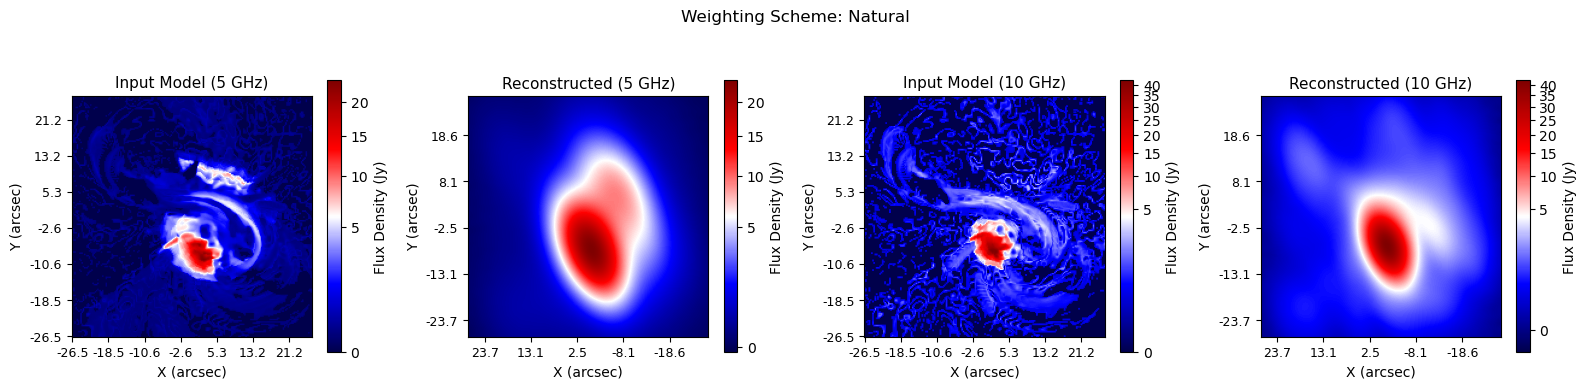

Skymodel size (200, 200) Image size (4096, 4096)
Image Res 0.05296551724137924 Model Res 0.26482758620689656
(4096, 4096)
(4096, 4096)


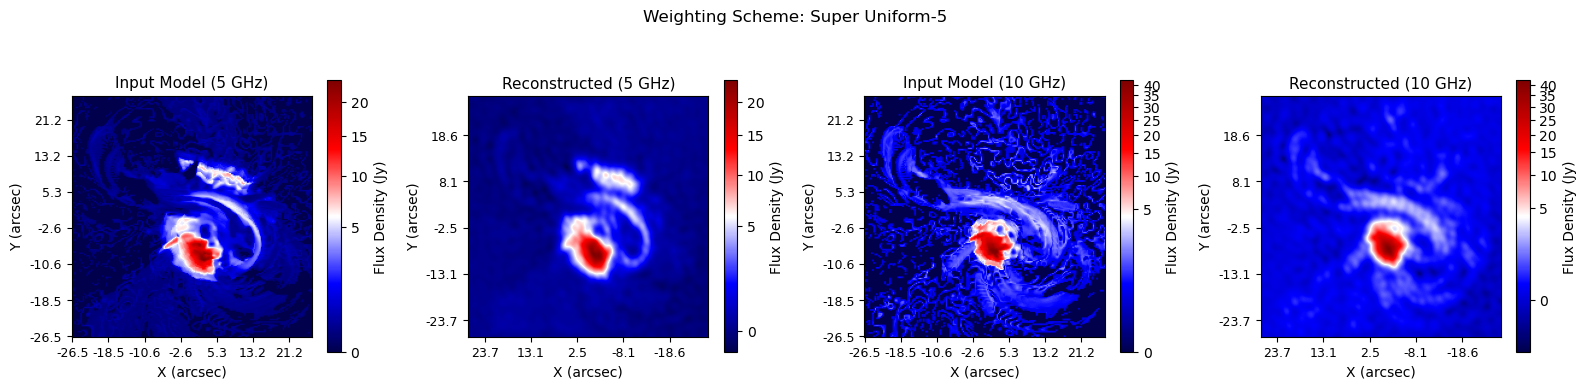

Skymodel size (200, 200) Image size (4096, 4096)
Image Res 0.05296551724137924 Model Res 0.26482758620689656
(4096, 4096)
(4096, 4096)


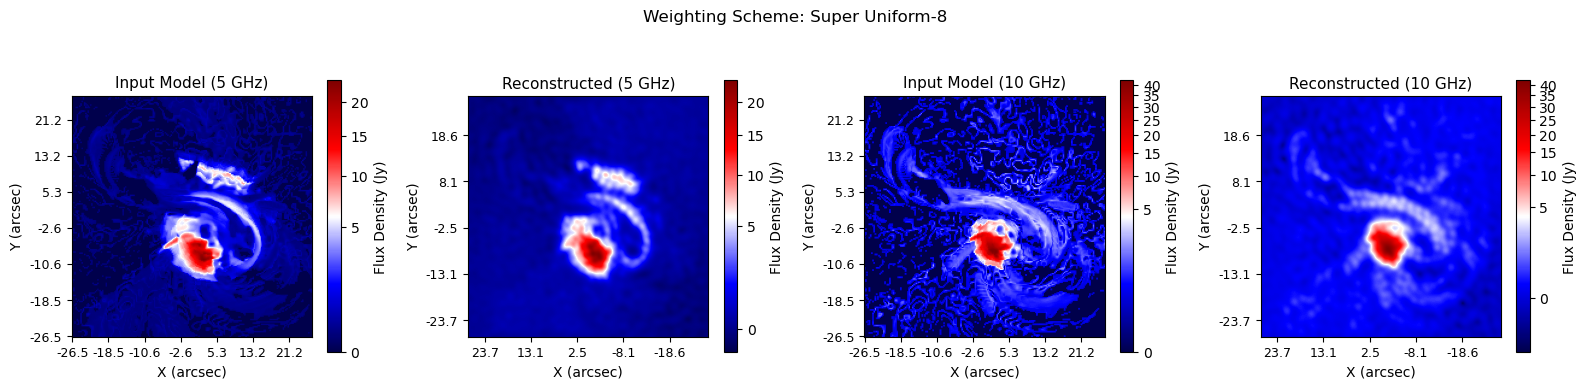

Skymodel size (200, 200) Image size (4096, 4096)
Image Res 0.05296551724137924 Model Res 0.26482758620689656
(4096, 4096)
(4096, 4096)


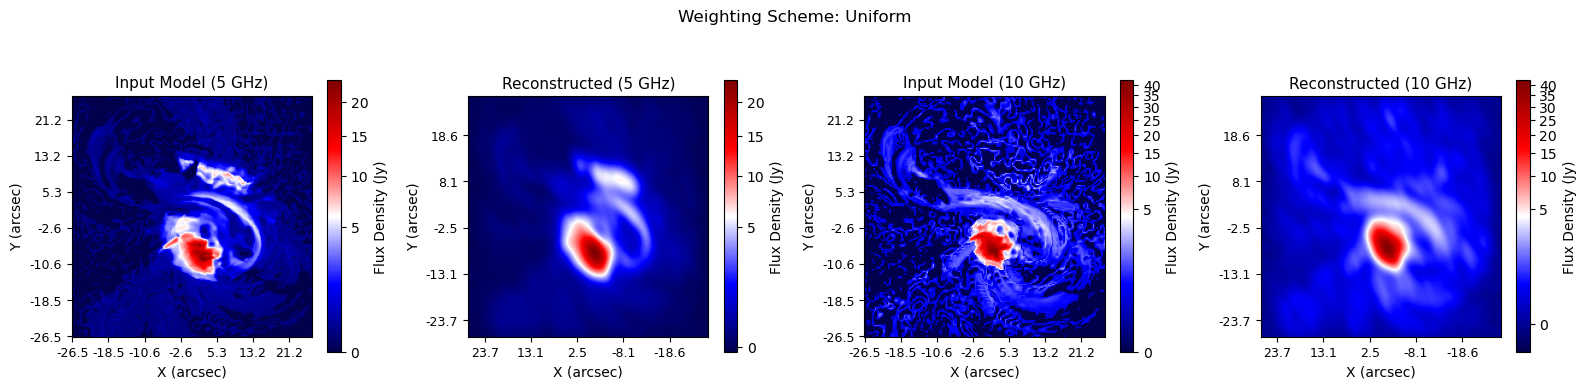

In [21]:
def set_ticks_labels(ax, xarr, yarr, xstep, ystep, xscale=1.0, yscale=1.0, xlabel='X (arcsec)', ylabel='Y (arcsec)'):
    """Helper function to set ticks and labels"""
    ax.set_xticks(np.arange(len(xarr))[::xstep])
    ax.set_yticks(np.arange(len(yarr))[::ystep])
    ax.set_xticklabels(np.round(xarr[::xstep] * xscale, 1), fontsize=tick_fontsize)
    ax.set_yticklabels(np.round(yarr[::ystep] * yscale, 1), fontsize=tick_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)

img_list0 = sorted(glob.glob('/data/rohit/ska-solar-sim-repo-paper/sc2/solar*5GHz*image.fits'))
img_list1 = sorted(glob.glob('/data/rohit/ska-solar-sim-repo-paper/sc2/solar*10GHz*image.fits'))
print(img_list0)

def get_img(img_list0,cutoff,ds):
    wsclean_img0=img_list0
    img_freq0 = wsclean_img0.split('_')[2]
    img_freq_int = int(img_freq0.split('G')[0])
    sm_img=ds['Stokes I'].sel(freq=img_freq_int, method='nearest').T.data[50:250,80:280]
    sm_img[sm_img<cutoff] = 0
    return sm_img
weight_str = ['Natural','Super Uniform-5','Super Uniform-8','Uniform']
for i in range(len(img_list0)):
    sm_img0 = get_img(img_list0[i],1.e-5,ds)
    sm_img1 = get_img(img_list1[i],2.e-5,ds)
    mapsun05,head = fits.getdata(img_list0[i],header=True)
    mapsun05 =  mapsun05[0][0]/np.max(mapsun05)*np.max(sm_img0)
    print('Skymodel size',sm_img0.shape,'Image size',mapsun05.shape)
    print('Image Res',head['CDELT2']*3600,'Model Res',res_sm2)
    img_ra =  (np.arange(mapsun05.shape[0])-int(mapsun05.shape[0]/2))*head['CDELT1']*3600
    img_dec = (np.arange(mapsun05.shape[1])-int(mapsun05.shape[1]/2))*head['CDELT2']*3600
    mapsun10 = fits.getdata(img_list1[i])[0][0]
    mapsun10 =  mapsun10/np.max(mapsun10)*np.max(sm_img1)
    ra_arr=(np.arange(sm_img0.shape[0])-int(sm_img0.shape[0]/2))
    dec_arr=(np.arange(sm_img0.shape[1])-int(sm_img0.shape[1]/2))
    # Plot the results 
    y=ds['Stokes I'].sel(freq=5, method='nearest').T
    # --- Create figure and axes ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    (ax0, ax1, ax2, ax3) = axes
    # --- Common style settings ---
    tick_fontsize = 9
    label_fontsize = 10
    title_fontsize = 11
    # --- Plot 5 GHz Input Model ---
    im0 = ax0.imshow(sm_img0 * 1e4, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.5))
    ax0.set_title('Input Model (5 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax0, ra_arr, dec_arr, 30, 30, res_sm2, res_sm2)
    cbar0 = fig.colorbar(im0, ax=ax0, shrink=0.8)
    cbar0.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    
    # --- Plot 5 GHz Reconstructed ---
    scale_num=0.7
    y1 = mapsun05[:, ::-1] * 1e4
    ny, nx = y1.shape
    print(y1.shape)
    im1 = ax1.imshow(y1, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.5))
    ax1.set_title('Reconstructed (5 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax1, img_ra, img_dec, 200, 200, xscale=1,yscale=1)
    cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    ax1.set_xlim(2048-520,2048+520)
    ax1.set_ylim(2048-520,2048+520)
    # --- Plot XX GHz Input Model ---
    im2 = ax2.imshow(sm_img1 * 1e4, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.3))
    ax2.set_title('Input Model (10 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax2, ra_arr, dec_arr, 30, 30, res_sm2, res_sm2)
    cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    
    # --- 10 GHz -----
    # --- Plot XX GHz Reconstructed ---
    scale_num=0.7
    y1 = mapsun10[:, ::-1] * 1e4
    print(y1.shape)
    im3 = ax3.imshow(y1, aspect='equal', origin='lower', cmap='seismic',norm=PowerNorm(0.3))
    ax3.set_title('Reconstructed (10 GHz)', fontsize=title_fontsize)
    set_ticks_labels(ax3, img_ra, img_dec, 200, 200, xscale=1,yscale=1)
    cbar1 = fig.colorbar(im3, ax=ax3, shrink=0.8)
    cbar1.set_label('Flux Density (Jy)', fontsize=label_fontsize)
    ax3.set_xlim(2048-520,2048+520)
    ax3.set_ylim(2048-520,2048+520)
    # --- Improve layout ---
    plt.suptitle('Weighting Scheme: '+weight_str[i])
    plt.tight_layout()
    plt.savefig(img_list0[i]+'.png')
    plt.show()